Initialisation de Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
from pymongo import MongoClient
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import json

In [2]:
spark = (
    SparkSession.builder
    .appName("SparkML_AttritionClient")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.execution.arrow.enabled", "true")
    .getOrCreate()
)

print(" Session Spark initialisée :", spark.version)

 Session Spark initialisée : 3.5.1


Lecture depuis MongoDB

In [3]:
client = MongoClient("mongodb://localhost:27017/")
db = client["Banques"]        
collection = db["Client"]

Export JSONL (pour lecture plus simple par Spark)

In [4]:
with open("../Data/dataClient.jsonl", "w") as out:
    for record in collection.find({}, {"_id": 0}):
        json.dump(record, out)
        out.write("\n")

Lecture du fichier avec Spark

In [5]:
df_raw = spark.read.json(r"../Data/dataClient.jsonl")
print(" Données importées depuis MongoDB")


 Données importées depuis MongoDB


In [6]:
df_raw.printSchema()


root
 |-- Age: double (nullable = true)
 |-- Balance: double (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- GenderBv: string (nullable = true)
 |-- GenderIndex: double (nullable = true)
 |-- Geography: string (nullable = true)
 |-- GeographyBc: string (nullable = true)
 |-- GeographyIndex: double (nullable = true)
 |-- HasCrCard: long (nullable = true)
 |-- IsActiveMember: long (nullable = true)
 |-- NumOfProducts: long (nullable = true)
 |-- Tenure: long (nullable = true)



In [7]:
df_raw.groupBy("Exited").count().show()

+------+-----+
|Exited|count|
+------+-----+
|     0| 7960|
|     1| 2037|
+------+-----+



Préparation des données

    Sélection uniquement des variables pertinentes

In [8]:
cols_features = [
    "CreditScore", "Age", "Balance", "EstimatedSalary",
    "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember",
    "GenderIndex", "GeographyIndex"
]

dataset = df_raw.select(["Exited"] + cols_features)

Convertir en numpy pour appliquer SMOTE


In [9]:
data_np = dataset.collect()
X = np.array([[getattr(row, c) for c in cols_features] for row in data_np])
y = np.array([row["Exited"] for row in data_np])

Rééquilibrage des classes

In [10]:
print("Avant SMOTE : ", np.bincount(y))
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)
print("Après SMOTE : ", np.bincount(y_bal))

# Conversion en DataFrame pandas
pdf = pd.DataFrame(X_bal, columns=cols_features)
pdf["Exited"] = y_bal


Avant SMOTE :  [7960 2037]
Après SMOTE :  [7960 7960]


Conversion vers Spark DataFrame

In [11]:
df_balanced = spark.createDataFrame(pdf)
df_balanced.groupBy("Exited").count().show()

+------+-----+
|Exited|count|
+------+-----+
|     0| 7960|
|     1| 7960|
+------+-----+



Assemblage des features et normalisation

In [12]:
assembleur = VectorAssembler(
    inputCols=cols_features,
    outputCol="features_non_scaled"
)

scaler = StandardScaler(
    inputCol="features_non_scaled",
    outputCol="features",
    withStd=True,
    withMean=True
)

Séparation des jeux de données

In [13]:
train_set, test_set = df_balanced.randomSplit([0.8, 0.2], seed=42)
print(f" Données d'entraînement : {train_set.count()}, test : {test_set.count()}")

 Données d'entraînement : 12749, test : 3171


Choix du modèle

In [14]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    labelCol="Exited", 
    featuresCol="features", 
    numTrees=100, 
    maxDepth=5, 
    seed=42
)


Construction du pipeline

In [15]:
pipeline = Pipeline(stages=[assembleur, scaler, rf])


Entraînement du modèle

ParamGrid pour optimiser hyperparamètres

In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [17]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 150])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .addGrid(rf.maxBins, [32, 64])
             .build())

Evaluateur

In [18]:
evaluator = BinaryClassificationEvaluator(labelCol="Exited", metricName="areaUnderROC")

Cross-Validation

In [19]:
cv = CrossValidator(
                    estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=1,  
                    seed=42)

# Entraînement du modèle avec CV

In [20]:
cv_model = cv.fit(train_set)

Meilleur modèle et hyperparamètres

In [21]:
best_model = cv_model.bestModel
rf_best = best_model.stages[-1]  
print(f"Meilleurs paramètres RF : numTrees={rf_best.getNumTrees}, maxDepth={rf_best.getOrDefault('maxDepth')} , maxBins : {rf_best.getOrDefault('maxBins')}")

Meilleurs paramètres RF : numTrees=150, maxDepth=15 , maxBins : 64


Prédictions sur le test set

In [22]:
predictions = cv_model.bestModel.transform(train_set)

# Aperçu des prédictions
predictions.select("Exited", "prediction", "probability").show(10)


+------+----------+--------------------+
|Exited|prediction|         probability|
+------+----------+--------------------+
|     1|       1.0|[0.13133333333333...|
|     0|       0.0|[0.95364980833781...|
|     0|       0.0|[0.97470861037284...|
|     0|       0.0|[0.84967214851661...|
|     0|       0.0|[0.98219144396245...|
|     0|       0.0|[0.96504265550465...|
|     0|       0.0|[0.91605079241554...|
|     0|       0.0|[0.98647752122316...|
|     1|       1.0|[0.07291402711397...|
|     0|       0.0|[0.90893870081912...|
+------+----------+--------------------+
only showing top 10 rows



Évaluation AUC-ROC

In [23]:
roc_auc = evaluator.evaluate(predictions)
print(f" ROC-AUC sur le jeu de test : {roc_auc:.4f}")

 ROC-AUC sur le jeu de test : 0.9994


Calcul des autres métriques : Accuracy, Precision, Recall, F1

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# F1-score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1_score:.4f}")


Accuracy : 0.9880
Precision : 0.9881
Recall : 0.9880
F1-score : 0.9880


Matrice de confusion

Accuracy : 0.9880
Precision : 0.9940
Recall : 0.9819
F1-score : 0.9879
AUC-ROC : 0.9994


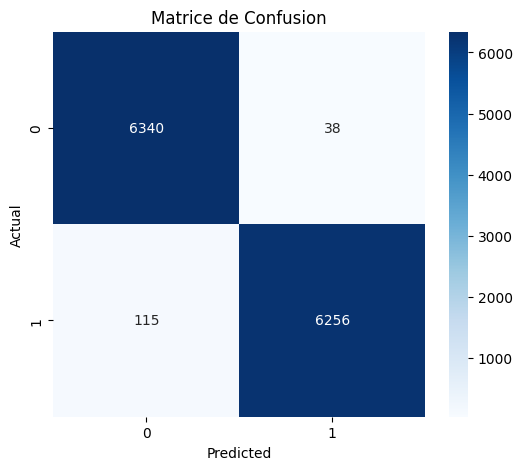

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#  Convertir les prédictions Spark en Pandas
pdf = predictions.select("Exited", "prediction", "probability").toPandas()

#  Calcul des métriques
y_true = pdf['Exited']
y_pred = pdf['prediction']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Pour l'AUC-ROC, prendre la probabilité de la classe positive (1)
y_prob = pdf['probability'].apply(lambda x: x[1])
auc = roc_auc_score(y_true, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC : {auc:.4f}")

#  Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de Confusion')
plt.show()


Sauvegarder le modele

In [26]:
type(cv_model.bestModel)

pyspark.ml.pipeline.PipelineModel

In [27]:
from pyspark.ml import PipelineModel

model_path = r"C:\Users\elabi\OneDrive\Desktop\Prédiction de l'Attrition Client Bancaire\Modele"
cv_model.bestModel.write().overwrite().save(model_path)


Py4JJavaError: An error occurred while calling o26567.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1623)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1623)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1609)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1609)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1(Pipeline.scala:250)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1$adapted(Pipeline.scala:247)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.saveImpl(Pipeline.scala:247)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.saveImpl(Pipeline.scala:346)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.hadoop.mapred.FileOutputCommitter.commitJob(FileOutputCommitter.java:136)
	at org.apache.hadoop.mapred.OutputCommitter.commitJob(OutputCommitter.java:291)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$3(SparkHadoopWriter.scala:100)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	... 68 more
